<a href="https://colab.research.google.com/github/GuyKaptue/scientific_research/blob/colab_code/local_volstility_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate the synthetic data


In [1]:
import gc
from IPython.display import clear_output

# Alle Variablen löschen
%reset_selective -f all

# Garbage Collection ausführen
gc.collect()

# Ausgabe löschen
clear_output()

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm

In [3]:
class SyntheticDataGenerator:
    def __init__(self, S0=100, r=0.01, q=0.005, n_strikes=20, n_maturities=10):
        """
        Initialize the synthetic data generator.

        Parameters:
        - S0: Initial asset price
        - r: Risk-free interest rate
        - q: Dividend yield
        - n_strikes: Number of strike prices
        - n_maturities: Number of maturities
        """
        self.S0 = S0
        self.r = r
        self.q = q
        self.n_strikes = n_strikes
        self.n_maturities = n_maturities
        self.strikes = np.linspace(80, 170, n_strikes)
        self.maturities = np.linspace(0.1, 2.0, n_maturities)

    def local_volatility(self, K, T):
        """
        Define a synthetic local volatility surface.
        """
        base_vol = 0.2
        smile = 0.1 * np.exp(-((K - self.S0)**2) / 500)
        term_structure = 0.05 * np.sin(2 * np.pi * T)
        return base_vol + smile + term_structure

    def black_scholes_call(self, S, K, T, r, sigma):
        """
        Compute the Black-Scholes price of a European call option.
        """
        if T <= 0 or sigma <= 0:
            return max(S - K, 0)
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    def generate(self):
        """
        Generate the synthetic dataset.

        Returns:
        - DataFrame with columns: Strike, Maturity, LocalVolatility, OptionPrice
        """
        data = []
        for T in self.maturities:
            for K in self.strikes:
                sigma = self.local_volatility(K, T)
                price = self.black_scholes_call(self.S0, K, T, self.r, sigma)
                data.append({
                    'Strike': K,
                    'Maturity': T,
                    'LocalVolatility': sigma,
                    'OptionPrice': price
                })
        return pd.DataFrame(data)


# Implement a data visualizer class

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

In [5]:

class DataVisualizer:
    def __init__(self, df, n_strikes=20, n_maturities=10):
        """
        Visualization class for synthetic option data.

        Parameters:
        - synthetic_data_generator: Instance of SyntheticDataGenerator
        - df: DataFrame with columns [Strike, Maturity, LocalVolatility, OptionPrice]
        - n_strikes: number of strike points (grid shape)
        - n_maturities: number of maturity points (grid shape)
        """
        self.df = df
        self.n_strikes = n_strikes
        self.n_maturities = n_maturities

        # Reshape into grids for surface/contour plots
        self.X = df["Strike"].values.reshape(n_maturities, n_strikes)
        self.Y = df["Maturity"].values.reshape(n_maturities, n_strikes)
        self.Z_vol = df["LocalVolatility"].values.reshape(n_maturities, n_strikes)
        self.Z_price = df["OptionPrice"].values.reshape(n_maturities, n_strikes)

    # ========================================================
    # 1. Heatmaps
    # ========================================================
    def plot_heatmaps(self):
        pivot_vol = self.df.pivot_table(index="Maturity", columns="Strike", values="LocalVolatility")
        pivot_price = self.df.pivot_table(index="Maturity", columns="Strike", values="OptionPrice")

        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_vol, cmap="viridis")
        plt.title("Local Volatility Heatmap")
        plt.xlabel("Strike")
        plt.ylabel("Maturity")
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_price, cmap="plasma")
        plt.title("Option Price Heatmap")
        plt.xlabel("Strike")
        plt.ylabel("Maturity")
        plt.show()

    # ========================================================
    # 2. Contour plots
    # ========================================================
    def plot_contours(self):
        plt.figure(figsize=(10, 6))
        cp = plt.contourf(self.X, self.Y, self.Z_vol, cmap="viridis", levels=15)
        plt.colorbar(cp)
        plt.title("Local Volatility Contour")
        plt.xlabel("Strike")
        plt.ylabel("Maturity")
        plt.show()

        plt.figure(figsize=(10, 6))
        cp = plt.contourf(self.X, self.Y, self.Z_price, cmap="plasma", levels=15)
        plt.colorbar(cp)
        plt.title("Option Price Contour")
        plt.xlabel("Strike")
        plt.ylabel("Maturity")
        plt.show()

    # ========================================================
    # 3. 3D Surface plots
    # ========================================================
    def plot_surfaces(self):
        fig = plt.figure(figsize=(12, 6))

        ax = fig.add_subplot(121, projection='3d')
        ax.plot_surface(self.X, self.Y, self.Z_vol, cmap="viridis")
        ax.set_title("Local Volatility Surface")
        ax.set_xlabel("Strike")
        ax.set_ylabel("Maturity")
        ax.set_zlabel("Volatility")

        ax2 = fig.add_subplot(122, projection='3d')
        ax2.plot_surface(self.X, self.Y, self.Z_price, cmap="plasma")
        ax2.set_title("Option Price Surface")
        ax2.set_xlabel("Strike")
        ax2.set_ylabel("Maturity")
        ax2.set_zlabel("Price")

        plt.show()

    # ========================================================
    # 4. Smiles and term structures
    # ========================================================
    def plot_slices(self, maturities_to_plot=[0.25, 1.0, 2.0], strikes_to_plot=[90, 100, 110]):
        # Smiles
        plt.figure(figsize=(10, 6))
        for T in maturities_to_plot:
            slice_df = self.df[np.isclose(self.df["Maturity"], T)]
            plt.plot(slice_df["Strike"], slice_df["LocalVolatility"], label=f"T={T}")
        plt.title("Volatility Smiles at Different Maturities")
        plt.xlabel("Strike")
        plt.ylabel("Local Volatility")
        plt.legend()
        plt.show()

        # Term structures
        plt.figure(figsize=(10, 6))
        for K in strikes_to_plot:
            slice_df = self.df[np.isclose(self.df["Strike"], K)]
            plt.plot(slice_df["Maturity"], slice_df["LocalVolatility"], label=f"K={K}")
        plt.title("Volatility Term Structure at Different Strikes")
        plt.xlabel("Maturity")
        plt.ylabel("Local Volatility")
        plt.legend()
        plt.show()

    # ========================================================
    # 5. Interactive 3D Plotly surfaces
    # ========================================================
    def plot_interactive_surfaces(self):
        fig_vol = px.surface(
            x=np.unique(self.df["Strike"]),
            y=np.unique(self.df["Maturity"]),
            z=self.Z_vol,
            title="Interactive Local Volatility Surface",
            labels={"x": "Strike", "y": "Maturity", "z": "Volatility"}
        )
        fig_vol.show()

        fig_price = px.surface(
            x=np.unique(self.df["Strike"]),
            y=np.unique(self.df["Maturity"]),
            z=self.Z_price,
            title="Interactive Option Price Surface",
            labels={"x": "Strike", "y": "Maturity", "z": "Price"}
        )
        fig_price.show()


# Loading synthetic data

In [5]:
synthetic_data_generator = SyntheticDataGenerator(n_maturities=100, n_strikes=150)
df = synthetic_data_generator.generate()

df.head()

,Strike,Maturity,LocalVolatility,OptionPrice
0,80.000000,0.1,0.274322,20.091901
1,80.604027,0.1,0.276512,19.493389
2,81.208054,0.1,0.278737,18.896525
3,81.812081,0.1,0.280992,18.301727
4,82.416107,0.1,0.283271,17.709471


In [7]:
df.describe()

,Strike,Maturity,LocalVolatility,OptionPrice
count,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06
mean,1.250000e+02,1.050000e+00,2.387073e-01,5.950734e+00
std,2.599810e+01,5.490317e-01,5.231269e-02,7.052759e+00
min,8.000000e+01,1.000000e-01,1.500057e-01,1.783275e-13
25%,1.025000e+02,5.750000e-01,1.973642e-01,2.448273e-01
50%,1.250000e+02,1.050000e+00,2.414368e-01,2.221096e+00
75%,1.475000e+02,1.525000e+00,2.726478e-01,1.088300e+01
max,1.700000e+02,2.000000e+00,3.499999e-01,2.591547e+01


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Strike           1500000 non-null  float64
 1   Maturity         1500000 non-null  float64
 2   LocalVolatility  1500000 non-null  float64
 3   OptionPrice      1500000 non-null  float64
dtypes: float64(4)
memory usage: 45.8 MB
None


# Visualize the data

In [9]:
# Initialize visualizer
n_strikes=synthetic_data_generator.n_strikes
n_maturities=synthetic_data_generator.n_maturities
data_visualizer = DataVisualizer(df, n_strikes, n_maturities)



# Model Calibration

In [9]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.utils import resample


# ========================================================
# Helper Functions
# ========================================================

def black_scholes_call(S, K, T, r, sigma):
    """
    Calculates the Black-Scholes price for a European call option.
    """
    S = np.asarray(S, dtype=float)
    K = np.asarray(K, dtype=float)
    T = np.asarray(T, dtype=float)
    sigma = np.asarray(sigma, dtype=float)

    # Avoid numerical issues with very small sigma or T
    eps = 1e-12
    sigma = np.maximum(sigma, eps)
    T = np.maximum(T, eps)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def prepare_calibration_data(df, data_type="synthetic", use_pricing_model=False):
    """
    Prepares the features (X) and targets (y) for calibration.

    Mode 1: Direct volatility calibration (synthetic data).
    Mode 2: Indirect calibration via option prices (real data).
    """
    X = df[['Strike', 'Maturity']].values

    if data_type == "synthetic":
        y = df['LocalVolatility'].values
        mode = 1
        notes = (
            "Direct Volatility Calibration:\n"
            "✅ Fast and ideal for testing against known synthetic surfaces.\n"
            "❌ Not applicable to real market data; ignores pricing dynamics."
        )
    elif data_type == "real":
        if use_pricing_model:
            y = df['OptionPrice'].values
            mode = 2
            notes = (
                "Indirect Calibration via Option Prices:\n"
                "✅ Matches real-world calibration; learns volatility from prices.\n"
                "✅ Extendable with pricing models (e.g., Dupire PDE / MC).\n"
                "❌ Requires pricing engine; more computationally intensive."
            )
        else:
            raise ValueError("Real market data requires a pricing model for calibration.")
    else:
        raise ValueError("data_type must be 'synthetic' or 'real'.")

    return X, y, mode, notes


# ---
#
# ---


# ========================================================
# Volatility Calibrator Class
# ========================================================
class VolatilityCalibrator:
    """
    Calibrates a local volatility surface using various machine learning methods.
    """
    def __init__(self, df, method="neural_net", regularization="l2", alpha=0.5,
                 device=None, seed=42, data_type="synthetic", use_pricing_model=False,
                 S0=100.0, r=0.01):

        required_cols = {"Strike", "Maturity", "OptionPrice", "LocalVolatility"}
        if not required_cols.issubset(df.columns):
            raise ValueError(f"DataFrame must contain {required_cols}")

        self.df = df.copy()
        if isinstance(method, (list, tuple)):
            self.methods = list(method)
        else:
            self.methods = [method]
        self.regularization = regularization
        self.alpha = alpha

        # Underlyer and rates for pricing-based calibration (mode=2)
        self.S0 = S0
        self.r = r

        # Prepare data based on the specified type and mode
        self.X, self.y, self.mode, self.notes = prepare_calibration_data(
            df, data_type=data_type, use_pricing_model=use_pricing_model
        )

        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)

        # Reproducibility
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Device
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Storage
        self.trained_models = {}
        self.calibration_time = {}

        # RL parameterization placeholders
        self.rl_params = None
        self.rl_basis_centers = None
        self.rl_basis_scales = None
        self.rl_n_features = None

    # --------------------------------------------------------
    # Neural Network Model
    # --------------------------------------------------------
    class VolNet(nn.Module):
        """A simple feed-forward neural network for volatility surface regression."""
        def __init__(self):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(2, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        def forward(self, x):
            return self.model(x)

    def train_neural_net(self, epochs=1000, lr=0.001, lambda_reg=1e-4, patience=50):
        """Trains the neural network model with early stopping."""
        X_train, X_val, y_train, y_val = train_test_split(
            self.X_scaled, self.y, test_size=0.2, random_state=42
        )

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(self.device)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(self.device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32).to(self.device)

        model = self.VolNet().to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        best_loss = float("inf")
        patience_counter = 0

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_tensor)
            loss = criterion(output, y_train_tensor)

            # Regularization
            reg = 0.0
            if self.regularization == "l2":
                reg = sum(torch.norm(p) ** 2 for p in model.parameters())
            elif self.regularization == "l1":
                reg = sum(torch.norm(p, 1) for p in model.parameters())
            elif self.regularization == "elastic_net":
                reg = sum(self.alpha * torch.norm(p, 1) + (1 - self.alpha) * torch.norm(p) ** 2
                          for p in model.parameters())

            total_loss = loss + lambda_reg * reg
            total_loss.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val_tensor)
                val_loss = criterion(val_pred, y_val_tensor)

            if epoch % 100 == 0:
                print(f"[NN] Epoch {epoch}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

            # Early stopping
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                patience_counter = 0
                best_model_state = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("[NN] Early stopping triggered.")
                    model.load_state_dict(best_model_state)
                    break

        self.trained_models["neural_net"] = model
        return model

    def predict_neural_net(self, X_input):
        """Predicts volatility using the trained neural network."""
        model = self.trained_models.get("neural_net")
        if model is None:
            raise ValueError("Neural net not trained yet.")
        model.eval()
        X_scaled = self.scaler.transform(X_input)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            return model(X_tensor).cpu().numpy().flatten()

    # --------------------------------------------------------
    # Gaussian Process Model
    # --------------------------------------------------------
    # ========================================================
    # Optimized Gaussian Process Model
    # ========================================================
    def train_gaussian_process(self, kernel="matern", n_samples=1000):
        """
        Trains a Gaussian Process Regressor with optimizations for large datasets.

        Parameters:
        - kernel: The kernel type to use ("matern" or "rbf").
        - n_samples: Number of data points to subsample for training the GP.
                    Set to None to use the full dataset.
        """
        # 1. Subsample the training data to reduce memory and time complexity
        if n_samples and len(self.X_scaled) > n_samples:
            print(f"Subsampling to {n_samples} points for GP training...")
            X_sub, y_sub = resample(self.X_scaled, self.y, n_samples=n_samples, random_state=42)
        else:
            X_sub, y_sub = self.X_scaled, self.y

        # Define the kernel
        if kernel == "matern":
            k = C(1.0) * Matern(length_scale=1.0, nu=1.5)
        elif kernel == "rbf":
            k = C(1.0) * RBF(length_scale=1.0)
        else:
            raise ValueError("Unsupported kernel")

        # 2. Reduce the number of optimizer restarts to save time
        gp = GaussianProcessRegressor(
            kernel=k,
            n_restarts_optimizer=2,  # Reduced from 10 to 2 for a faster, more memory-efficient fit
            alpha=1e-4,
            normalize_y=True,
            random_state=42
        )

        # Convert data to float32 to reduce memory usage by half, if it's not already
        X_sub = X_sub.astype(np.float32)
        y_sub = y_sub.astype(np.float32)

        # Fit the GP model
        gp.fit(X_sub, y_sub)
        self.trained_models["gaussian_process"] = gp
        return gp

    def predict_gaussian_process(self, X_input):
        """Predicts volatility and standard deviation using the trained GP."""
        gp = self.trained_models.get("gaussian_process")
        if gp is None:
            raise ValueError("Gaussian process not trained yet.")
        X_scaled = self.scaler.transform(X_input)
        y_pred, y_std = gp.predict(X_scaled, return_std=True)
        return y_pred, y_std

    # --------------------------------------------------------
    # Reinforcement Learning Calibration (Evolution Strategies)
    # --------------------------------------------------------
    def _init_rl_basis(self, n_centers_K=8, n_centers_T=6, length_scale_K=10.0, length_scale_T=0.5):
        """Initializes the RBF basis for the RL model."""
        K_vals = np.unique(self.df["Strike"].values)
        T_vals = np.unique(self.df["Maturity"].values)

        Ks = np.linspace(K_vals.min(), K_vals.max(), n_centers_K)
        Ts = np.linspace(T_vals.min(), T_vals.max(), n_centers_T)

        centers = np.array([(k, t) for t in Ts for k in Ks])  # (n_features, 2)
        scales = np.array([length_scale_K, length_scale_T])  # anisotropic

        self.rl_basis_centers = centers
        self.rl_basis_scales = scales
        self.rl_n_features = centers.shape[0]

    def _rbf_features(self, X):
        """Computes RBF features for the given input data."""
        # X: (N,2) with columns [Strike, Maturity]
        if self.rl_basis_centers is None:
            raise RuntimeError("RL basis not initialized.")

        diff = X[:, None, :] - self.rl_basis_centers[None, :, :]  # (N, n_feat, 2)
        inv_ls2 = 1.0 / (self.rl_basis_scales**2)                   # (2,)
        quad = (diff**2) * inv_ls2
        dist2 = quad.sum(axis=2)                                 # (N, n_feat)
        Phi = np.exp(-0.5 * dist2)                               # RBF features

        # Add a bias term
        Phi = np.concatenate([Phi, np.ones((Phi.shape[0], 1))], axis=1) # (N, n_feat+1)
        return Phi

    def _sigma_from_params(self, X, w):
        """Maps RL parameters (w) to a volatility surface."""
        Phi = self._rbf_features(X)
        s = Phi @ w  # raw output
        # Use a positive mapping (e.g., softplus) to ensure volatility is non-negative
        return np.log1p(np.exp(s)) + 1e-6

    def _pricing_error_mse(self, X, target_prices, w):
        """Calculates the mean squared error of option prices."""
        sigma = self._sigma_from_params(X, w)
        prices = black_scholes_call(self.S0, X[:, 0], X[:, 1], self.r, sigma)
        return float(np.mean((prices - target_prices)**2))

    def _vol_error_mse(self, X, target_vol, w):
        """Calculates the mean squared error of volatility."""
        sigma = self._sigma_from_params(X, w)
        return float(np.mean((sigma - target_vol)**2))

    def train_reinforcement_learning(
        self,
        episodes=400,
        population=32,
        sigma_action=0.05,
        lr=0.1,
        n_centers_K=8,
        n_centers_T=6,
        length_scale_K=10.0,
        length_scale_T=0.5,
        val_split=0.2,
        early_stop=50,
        verbose=True
    ):
        """
        Evolution Strategies for volatility surface calibration.
        Optimizes a vector of parameters `w` that defines the volatility surface.
        """
        # Initialize basis and params
        self._init_rl_basis(n_centers_K=n_centers_K, n_centers_T=n_centers_T,
                            length_scale_K=length_scale_K, length_scale_T=length_scale_T)
        n_feat = self.rl_n_features + 1  # bias added
        w = np.zeros(n_feat, dtype=float)

        # Train/validation split
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=val_split, random_state=42
        )

        best_w = w.copy()

        if self.mode == 2:
            best_loss = self._pricing_error_mse(X_val, y_val, w)
        else:
            best_loss = self._vol_error_mse(X_val, y_val, w)

        no_improve = 0

        for ep in range(episodes):
            deltas = np.random.randn(population, n_feat) * sigma_action
            rewards = np.zeros(population, dtype=float)

            # Evaluate population
            for i in range(population):
                w_i = w + deltas[i]
                if self.mode == 2:
                    loss_i = self._pricing_error_mse(X_train, y_train, w_i)
                    rewards[i] = -loss_i
                else:
                    loss_i = self._vol_error_mse(X_train, y_train, w_i)
                    rewards[i] = -loss_i

            # Normalize rewards for NES update
            r_mean = rewards.mean()
            r_std = rewards.std() + 1e-8
            norm_rewards = (rewards - r_mean) / r_std

            # NES gradient estimator update
            grad_est = (norm_rewards[:, None] * deltas).mean(axis=0) / sigma_action
            w = w + lr * grad_est

            # Validation loss
            if self.mode == 2:
                val_loss = self._pricing_error_mse(X_val, y_val, w)
            else:
                val_loss = self._vol_error_mse(X_val, y_val, w)

            if val_loss < best_loss - 1e-8:
                best_loss = val_loss
                best_w = w.copy()
                no_improve = 0
            else:
                no_improve += 1

            if verbose and (ep % 20 == 0 or ep == episodes - 1):
                msg_target = "Price MSE" if self.mode == 2 else "Vol MSE"
                print(f"[RL] Ep {ep:03d} | Train {msg_target}: {(-rewards).mean():.6f} | Val {msg_target}: {val_loss:.6f}")

            if no_improve >= early_stop:
                if verbose:
                    print("[RL] Early stopping: no improvement on validation.")
                break

        # Store best params
        self.rl_params = best_w
        self.trained_models["reinforcement_learning"] = {"w": best_w}
        return best_w

    def predict_reinforcement_learning(self, X_input):
        """Predicts volatility using the trained RL model."""
        if self.rl_params is None:
            raise RuntimeError("RL model not trained. Call train_reinforcement_learning() first.")
        return self._sigma_from_params(X_input, self.rl_params)

    # --------------------------------------------------------
    # Unified Interface
    # --------------------------------------------------------
    def calibrate(self):
        """
        Runs calibration for all selected methods.
        """
        for method in self.methods:
            start = time.time()
            if method == "neural_net":
                self.train_neural_net()
            elif method == "gaussian_process":
                self.train_gaussian_process()
            elif method == "reinforcement_learning":
                self.train_reinforcement_learning()
            else:
                raise ValueError(f"Unknown method: {method}")
            end = time.time()
            self.calibration_time[method] = end - start
            print(f"[{method}] Calibration completed in {self.calibration_time[method]:.2f} seconds")

    def predict(self, X_input, method=None):
        """
        Predicts volatility for a given input using the specified method.
        If no method is specified, defaults to the first one in `self.methods`.
        """
        if method is None:
            if not self.methods:
                raise ValueError("No calibration method was specified during initialization.")
            method = self.methods[0]

        if method not in self.trained_models:
            raise ValueError(f"Model for '{method}' has not been calibrated yet.")

        if method == "neural_net":
            return self.predict_neural_net(X_input)
        elif method == "gaussian_process":
            # This method returns (pred, std), we return just the prediction
            y_pred, _ = self.predict_gaussian_process(X_input)
            return y_pred
        elif method == "reinforcement_learning":
            return self.predict_reinforcement_learning(X_input)
        else:
            raise ValueError(f"Prediction not supported for method {method}")


# Evaluator Prediction

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import linregress

# ========================================================
# Calibration Evaluator Class
# ========================================================
class CalibrationEvaluator:
    def __init__(self, calibrators, df):
        """
        Evaluation and visualization of volatility calibration results.

        Parameters:
        - calibrators: dict of {"ModelName": VolatilityCalibrator instance}
        - df: DataFrame with calibration data
        """
        if not isinstance(calibrators, dict):
            raise ValueError("calibrators must be a dict of {name: VolatilityCalibrator}")

        self.calibrators = calibrators
        self.df = df
        self.results = {}

    # ========================================================
    # Metrics
    # ========================================================
    def evaluate(self, X, y_true, model_name):
        """
        Compute evaluation metrics for a given model.

        Parameters:
        - X: input features [[Strike, Maturity]]
        - y_true: ground truth volatility
        - model_name: name of the model to evaluate
        """
        calibrator = self.calibrators[model_name]
        preds = calibrator.predict(X)

        if isinstance(preds, tuple):  # Gaussian Process returns (y_pred, y_std)
            preds = preds[0]

        mse = mean_squared_error(y_true, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, preds)
        r2 = r2_score(y_true, preds)

        metrics = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}
        self.results[model_name] = metrics

        return metrics, preds

    def compare_models(self, X, y_true):
        """
        Compare all calibration models stored in self.calibrators.
        """
        comparison = {}
        for name in self.calibrators.keys():
            metrics, _ = self.evaluate(X, y_true, model_name=name)
            comparison[name] = metrics
        return pd.DataFrame(comparison).T

    # ========================================================
    # Visualization
    # ========================================================
    def plot_predictions(self, X, y_true, model_name, title=None):
        """
        Scatter plot of predicted vs true volatility for one model,
        including a linear trend line.
        """
        _, preds = self.evaluate(X, y_true, model_name=model_name)

        # Plot scatter plot
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=y_true, y=preds, alpha=0.6, label="Predictions")

        # Plot perfect prediction line (y=x)
        min_val = min(y_true.min(), preds.min())
        max_val = max(y_true.max(), preds.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")

        # Plot linear trend line
        slope, intercept, r_value, p_value, std_err = linregress(y_true, preds)
        plt.plot(y_true, intercept + slope * y_true, 'g-', label=f"Linear Trend (R²={r_value**2:.2f})")

        plt.xlabel("True Volatility")
        plt.ylabel("Predicted Volatility")
        plt.title(title or f"{model_name}: Predictions vs True")
        plt.legend()
        plt.grid(True)
        plt.axis('square') # Ensures the plot is a square
        plt.show()


    def plot_surface(self, X, y_true, model_name, title=None):
        """
        Plot 3D volatility surface (true vs predicted) for one model.
        """
        from mpl_toolkits.mplot3d import Axes3D

        _, preds = self.evaluate(X, y_true, model_name=model_name)

        fig = plt.figure(figsize=(14, 6))

        # True Surface
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(X[:, 0], X[:, 1], y_true, c=y_true, cmap="viridis")
        ax1.set_title("True Local Volatility")
        ax1.set_xlabel("Strike")
        ax1.set_ylabel("Maturity")
        ax1.set_zlabel("Volatility")

        # Predicted Surface
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(X[:, 0], X[:, 1], preds, c=preds, cmap="plasma")
        ax2.set_title(f"{model_name} Predicted Volatility")
        ax2.set_xlabel("Strike")
        ax2.set_ylabel("Maturity")
        ax2.set_zlabel("Volatility")

        plt.suptitle(title or f"{model_name}: Volatility Surface")
        plt.tight_layout()
        plt.show()

    def plot_model_comparison(self):
        """
        Barplot comparing stored model metrics.
        """
        if not self.results:
            raise ValueError("No model results stored. Run evaluate() or compare_models() first.")

        df_metrics = pd.DataFrame(self.results).T
        df_metrics.plot(kind="bar", figsize=(12, 7))
        plt.title("Model Performance Comparison")
        plt.ylabel("Error")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


In [11]:
import time
# 2. Initialize and calibrate models
calibrators = {}

In [13]:


# ==========================
# Neural Network
# ==========================
start = time.time()
nn_vol_calibrator = VolatilityCalibrator(df, method= "neural_net", regularization="elastic_net")
nn_vol_calibrator.calibrate()
end = time.time()
duration = end - start
print(f"[NeuralNet] Calibration completed in {duration:.2f} seconds")
calibrators["NeuralNet"] = nn_vol_calibrator

Using device: cpu
[NN] Epoch 0, Train Loss: 0.129619, Val Loss: 0.099411
[NN] Epoch 100, Train Loss: 0.001168, Val Loss: 0.001140
[NN] Epoch 200, Train Loss: 0.000558, Val Loss: 0.000546
[NN] Epoch 300, Train Loss: 0.000343, Val Loss: 0.000337
[NN] Epoch 400, Train Loss: 0.000266, Val Loss: 0.000265
[NN] Epoch 500, Train Loss: 0.000218, Val Loss: 0.000220
[NN] Epoch 600, Train Loss: 0.000161, Val Loss: 0.000162
[NN] Epoch 700, Train Loss: 0.000103, Val Loss: 0.000103
[NN] Epoch 800, Train Loss: 0.000086, Val Loss: 0.000085
[NN] Epoch 900, Train Loss: 0.000075, Val Loss: 0.000074
[neural_net] Calibration completed in 20.93 seconds
[NeuralNet] Calibration completed in 20.94 seconds


In [12]:
# ==========================
# Gaussian Process
# ==========================
start = time.time()
gp_vol_calibrator = VolatilityCalibrator(df, method="gaussian_process")
gp_vol_calibrator.calibrate()
end = time.time()
duration = end - start
print(f"[GaussianProcess] Calibration completed in {duration:.2f} seconds")
calibrators["GaussianProcess"] = gp_vol_calibrator

Using device: cpu
Subsampling to 1000 points for GP training...
[gaussian_process] Calibration completed in 16.02 seconds
[GaussianProcess] Calibration completed in 16.02 seconds


In [14]:
# ==========================
# Reinforcement Learning (Stub)
# ==========================
start = time.time()
rf_vol_calibrator = VolatilityCalibrator(df, method="reinforcement_learning")
rf_vol_calibrator.calibrate()
end = time.time()
duration = end - start
print(f"[ReinforcementLearning] Calibration completed in {duration:.2f} seconds")
calibrators["ReinforcementLearning"] = rf_vol_calibrator

Using device: cpu
[RL] Ep 000 | Train Vol MSE: 0.223564 | Val Vol MSE: 0.171300
[RL] Ep 020 | Train Vol MSE: 0.001852 | Val Vol MSE: 0.001578
[RL] Ep 040 | Train Vol MSE: 0.001751 | Val Vol MSE: 0.001219
[RL] Ep 060 | Train Vol MSE: 0.001672 | Val Vol MSE: 0.001118
[RL] Ep 080 | Train Vol MSE: 0.001680 | Val Vol MSE: 0.001256
[RL] Ep 100 | Train Vol MSE: 0.001569 | Val Vol MSE: 0.001093
[RL] Ep 120 | Train Vol MSE: 0.001508 | Val Vol MSE: 0.001015
[RL] Ep 140 | Train Vol MSE: 0.001245 | Val Vol MSE: 0.001016
[RL] Ep 160 | Train Vol MSE: 0.001322 | Val Vol MSE: 0.000849
[RL] Ep 180 | Train Vol MSE: 0.001190 | Val Vol MSE: 0.000701
[RL] Ep 200 | Train Vol MSE: 0.001178 | Val Vol MSE: 0.000808
[RL] Ep 220 | Train Vol MSE: 0.001210 | Val Vol MSE: 0.000833
[RL] Ep 240 | Train Vol MSE: 0.001554 | Val Vol MSE: 0.000776
[RL] Early stopping: no improvement on validation.
[reinforcement_learning] Calibration completed in 666.46 seconds
[ReinforcementLearning] Calibration completed in 666.47 seco

Evaluator and Visualization
Evaluating Model: GaussianProcess
Metrics: {'MSE': 3.186686886306774e-08, 'RMSE': np.float64(0.00017851293752293624), 'MAE': 4.5300671912739745e-05, 'R2': 0.9999883052153973}


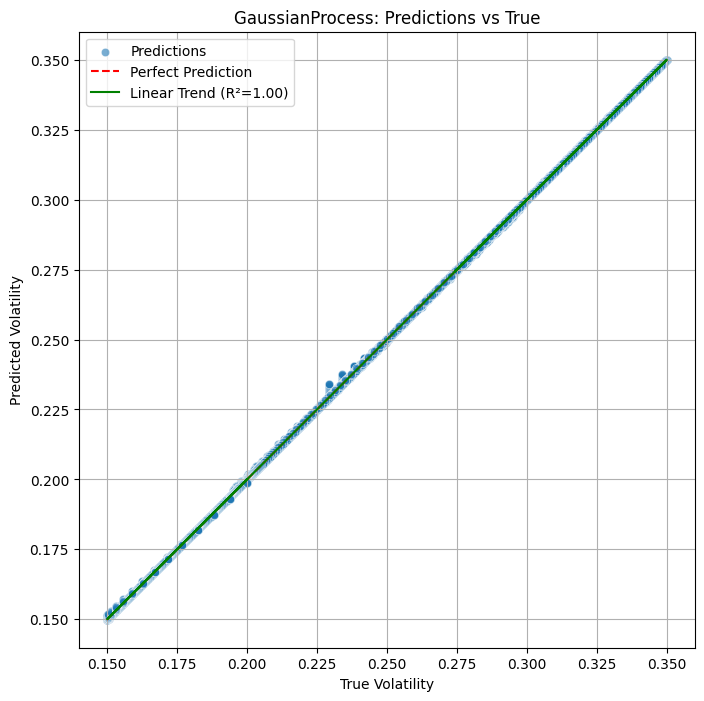

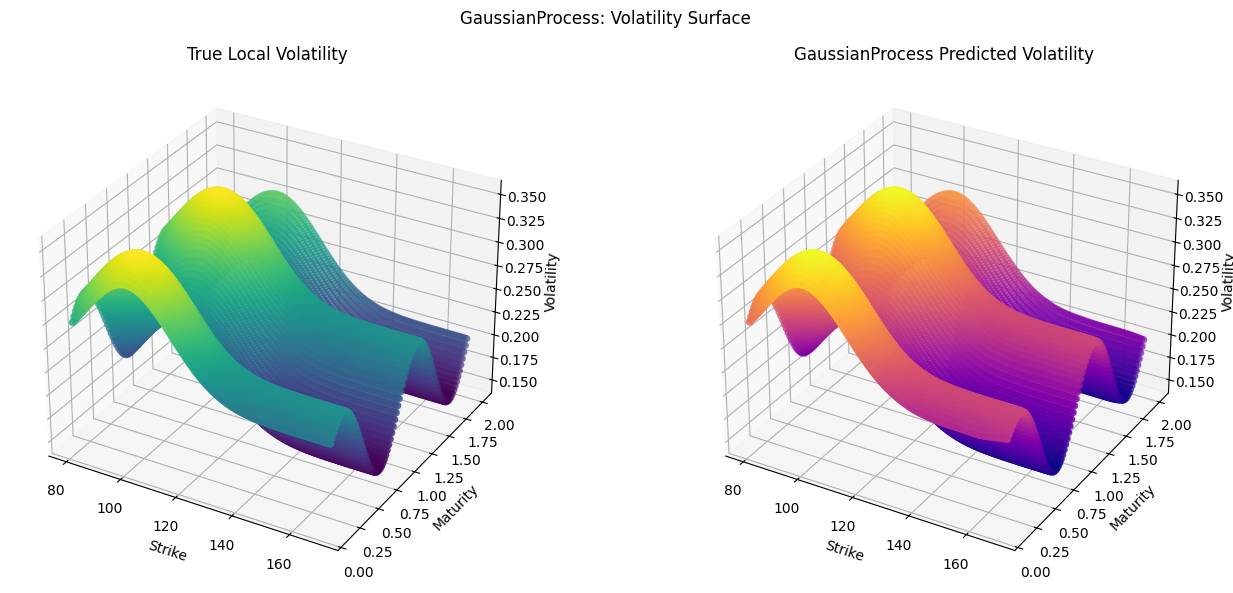

Evaluating Model: NeuralNet
Metrics: {'MSE': 6.388914338845946e-05, 'RMSE': np.float64(0.007993068458887328), 'MAE': 0.006438642674870015, 'R2': 0.976553398653954}


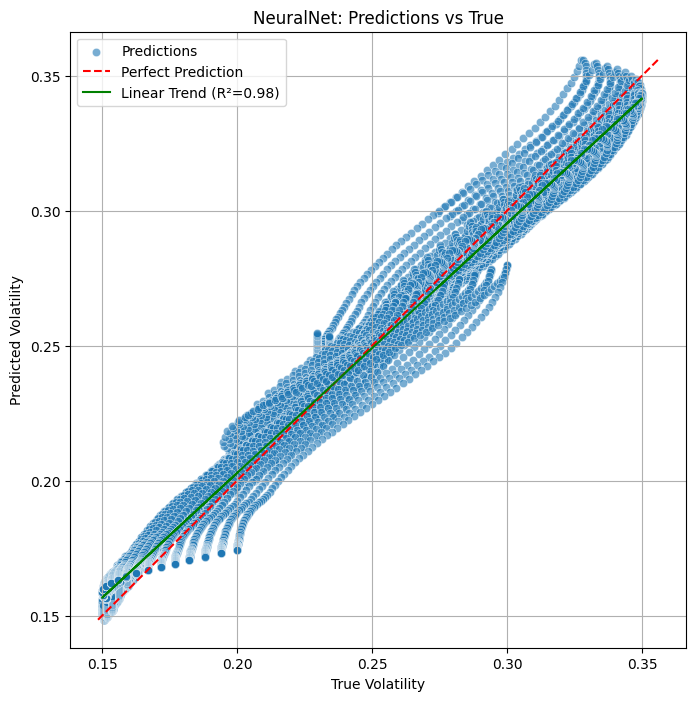

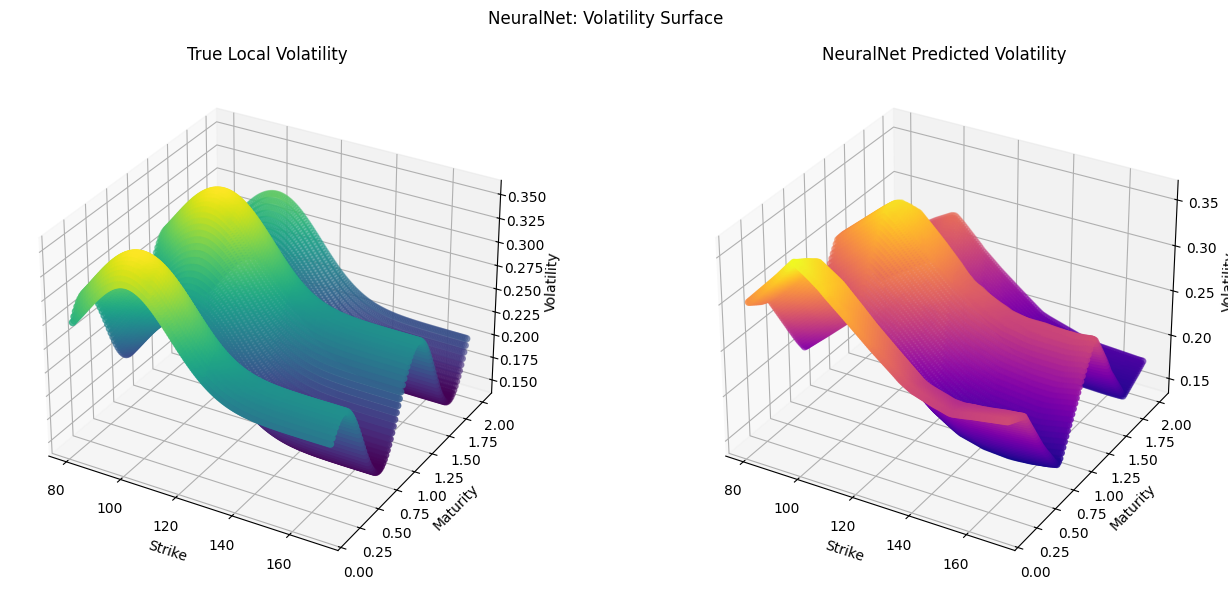

Evaluating Model: ReinforcementLearning
Metrics: {'MSE': 0.0006882147718469092, 'RMSE': np.float64(0.026233847827699795), 'MAE': 0.02228865338494207, 'R2': 0.7474328729398917}


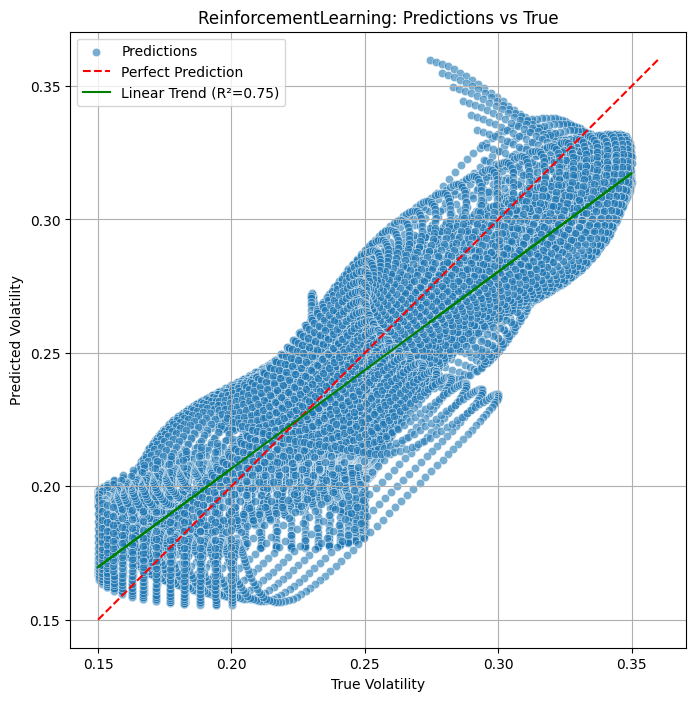

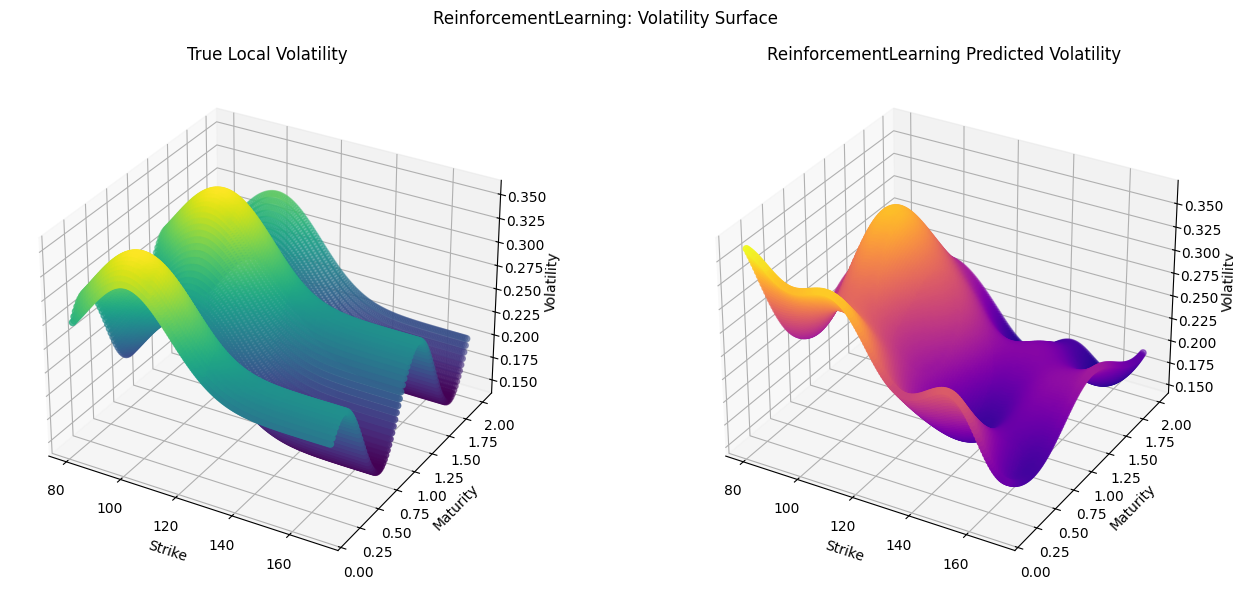


Model Comparison Table:
                                MSE      RMSE       MAE        R2
GaussianProcess        3.186687e-08  0.000179  0.000045  0.999988
NeuralNet              6.388914e-05  0.007993  0.006439  0.976553
ReinforcementLearning  6.882148e-04  0.026234  0.022289  0.747433


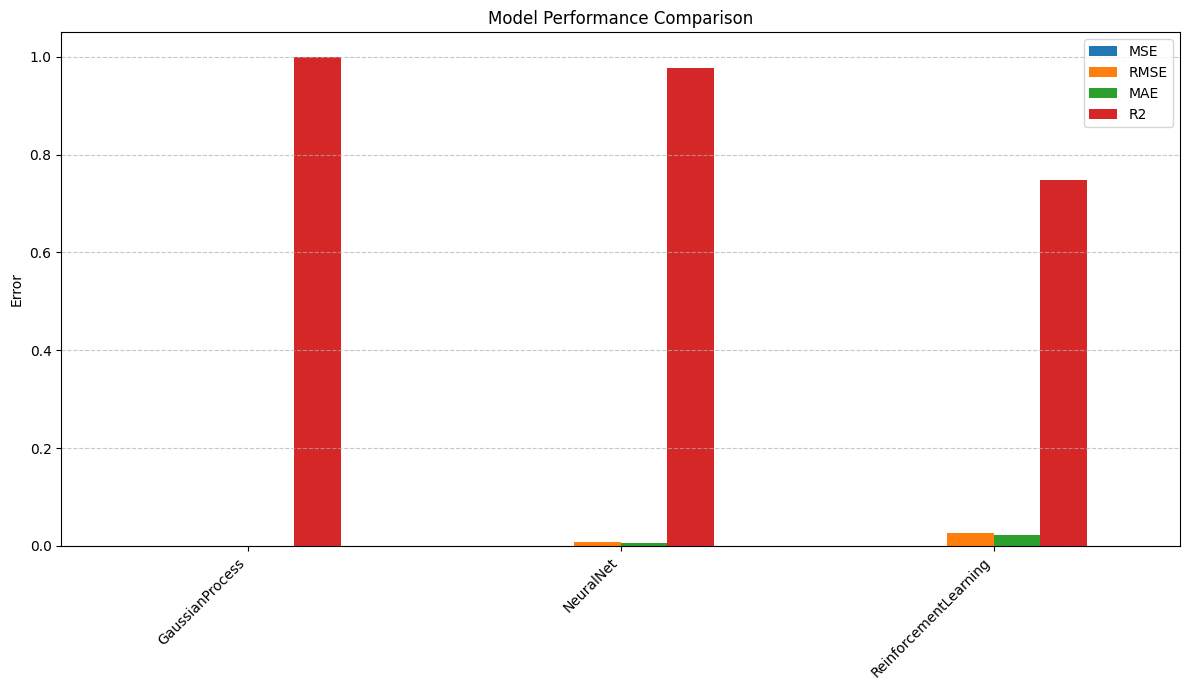

In [15]:
print("Evaluator and Visualization")
X = df[["Strike", "Maturity"]].values
y = df["LocalVolatility"].values

# 3. Initialize evaluator
evaluator = CalibrationEvaluator(calibrators, df)

# 4. Loop over models: metrics + visualizations
for model_name in calibrators.keys():
    print("="*60)
    print(f"Evaluating Model: {model_name}")

    # Metrics
    metrics, preds = evaluator.evaluate(X, y, model_name)
    print("Metrics:", metrics)

    # Prediction Scatter
    evaluator.plot_predictions(X, y, model_name)

    # Volatility Surface
    evaluator.plot_surface(X, y, model_name)

# 5. Compare models side by side
comparison_df = evaluator.compare_models(X, y)
print("\nModel Comparison Table:")
print(comparison_df)

# 6. Comparison bar chart
evaluator.plot_model_comparison()
